In [655]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


The equations of motion for a rotating rigid body are known as the Euler equations. The Euler equations describe the relationship between the angular velocities of a rigid body $(\omega_1, \omega_2, \omega_3)$ and its principal moments of inertia $(I_1, I_2, I_3)$. The equations are given by:
$$I_1\dot{\omega}_1+(I_3-I_2)\omega_2\omega_3=0$$
$$I_2\dot{\omega}_2+(I_1-I_3)\omega_3\omega_1=0$$
$$I_3\dot{\omega}_3+(I_2-I_1)\omega_1\omega_2=0$$
Where:
- $I_1$, $I_2$, and $I_3$ are the principal moments of inertia of the rigid body about its three principal axes.
- $\omega_1$, $\omega_2$, and $\omega_3$ are the angular velocities about the three principal axes.
- The dots above the angular velocities denote time derivatives (e.g., $\dot{\omega_1}$ is the time derivative of $\omega_1$).

These equations are derived from the conservation of angular momentum, which states that the total angular momentum of a closed system remains constant. The Euler equations are a set of coupled, nonlinear, first-order ordinary differential equations (ODEs) that describe the time evolution of the angular velocities of a rigid body.

To solve these equations numerically, we can use a numerical integration method, such as the Runge-Kutta 4th order method (RK4). The RK4 method is an iterative method that can approximate the solution to a system of ODEs, such as the Euler equations, with a given set of initial conditions.

To include the gravitational torque, we need to modify the Euler equations. Assuming that the center of mass of the rigid body is not at the origin, the gravitational torque τ can be calculated using the following formula:
$$\tau=r_{cm}\times F_g$$
Where:
- $\boldsymbol{\tau}$ is the gravitational torque vector.
- $\boldsymbol{r}_{cm}$ is the position vector of the center of mass of the rigid body relative to the origin.
- $\boldsymbol{F}_g$ is the gravitational force vector acting on the center of mass (i.e., $m \cdot g$, where $m$ is the mass of the rigid body and $g$ is the gravitational acceleration vector).

Now, we can modify the Euler equations to include the gravitational torque:
$$I_1\dot{\omega}_1+(I_3-I_2)\omega_2\omega_3=\tau_1$$
$$I_2\dot{\omega}_2+(I_1-I_3)\omega_3\omega_1=\tau_2$$
$$I_3\dot{\omega}_3+(I_2-I_1)\omega_1\omega_2=\tau_3$$
Where $\tau_1$, $\tau_2$, and $\tau_3$ are the components of the gravitational torque vector $\boldsymbol{\tau}$ expressed in the body-fixed frame.

Finally, we need to account for dissipative forces like air resistance and friction, which can cause a rotating body to lose energy and slow down over time. To model this, we add a damping term proportional to the angular velocity in each equation. This damping term represents the energy loss due to the dissipative forces.

To include damping in the simulation, we modify the Euler equations as follows:
$$I_1\dot{\omega}_1+(I_3-I_2)\omega_2\omega_3+b_1\omega_1=\tau_1$$
$$I_2\dot{\omega}_2+(I_1-I_3)\omega_3\omega_1+b_2\omega_2=\tau_2$$
$$I_3\dot{\omega}_3+(I_2-I_1)\omega_1\omega_2+b_3\omega_3=\tau_3$$
Where $b_1$, $b_2$, and $b_3$ are damping coefficients for each axis. The higher the coefficients, the faster the energy loss and the faster the angular velocities will tend to zero.

In [656]:
def gravitational_torque(angular_velocity, r_cm, m, g):
    w1, w2, w3 = angular_velocity
    x_cm, y_cm, z_cm = r_cm

    tau1 = m * g * (y_cm * w3 - z_cm * w2)
    tau2 = m * g * (z_cm * w1 - x_cm * w3)
    tau3 = m * g * (x_cm * w2 - y_cm * w1)

    return np.array([tau1, tau2, tau3])

In [657]:
def euler_equations(state, inertia, r_cm, m, g, damping):
    angular_velocity = state
    tau = gravitational_torque(angular_velocity, r_cm, m, g)

    I1, I2, I3 = inertia
    w1, w2, w3 = angular_velocity
    b1, b2, b3 = damping

    dw1 = ((I3 - I2) * w2 * w3 - b1 * w1 + tau[0]) / I1
    dw2 = ((I1 - I3) * w3 * w1 - b2 * w2 + tau[1]) / I2
    dw3 = ((I2 - I1) * w1 * w2 - b3 * w3 + tau[2]) / I3

    return np.array([dw1, dw2, dw3])

In [658]:
def rk4_step(state, h, inertia, r_cm, m, g, damping):
    k1 = h * euler_equations(state, inertia, r_cm, m, g, damping)
    k2 = h * euler_equations(state + k1/2, inertia, r_cm, m, g, damping)
    k3 = h * euler_equations(state + k2/2, inertia, r_cm, m, g, damping)
    k4 = h * euler_equations(state + k3, inertia, r_cm, m, g, damping)

    return state + (k1 + 2*k2 + 2*k3 + k4) / 6

In [659]:
def simulate(inertia, initial_state, r_cm, m, g, damping, t_total, dt):
    t = np.arange(0, t_total, dt)
    states = np.zeros((len(t), 3))
    states[0] = initial_state

    for i in range(1, len(t)):
        states[i] = rk4_step(states[i-1], dt, inertia, r_cm, m, g, damping)

    return t, states

In [660]:
def plot_phase_space(states):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(states[:, 0], states[:, 1], states[:, 2], s=1)
    ax.set_xlabel("w1")
    ax.set_ylabel("w2")
    ax.set_zlabel("w3")
    ax.set_title("Phase Space Diagram")
    plt.show()

In [661]:
def find_sleeping_period_end_time(states, t, dt):
    angular_velocity = states[:, 0]
    first_derivative = np.gradient(angular_velocity, dt)
    second_derivative = np.gradient(first_derivative, dt)
    zero_crossings = np.where(np.diff(np.sign(second_derivative)))[0]
    distances_between_zeroes = np.diff(zero_crossings)

    window_size = 5
    running_average_distance = np.convolve(distances_between_zeroes, np.ones(window_size) / window_size, mode='valid')

    threshold = np.zeros_like(distances_between_zeroes)
    threshold[:len(running_average_distance)] = 1.5 * running_average_distance

    end_time_index = np.where(distances_between_zeroes > threshold)[0]

    if len(end_time_index) > 0:
        return t[zero_crossings[end_time_index[0]]]
    else:
        return 60

8.91


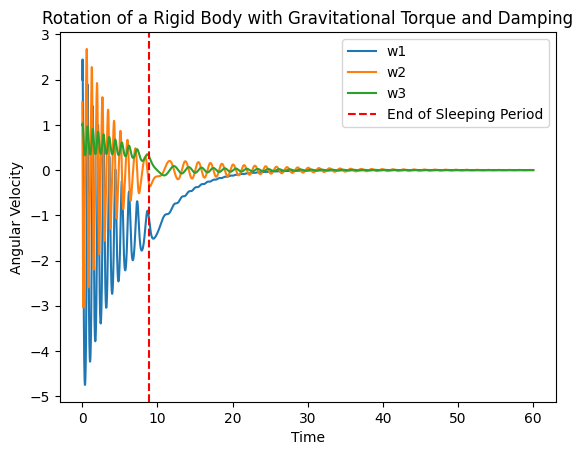

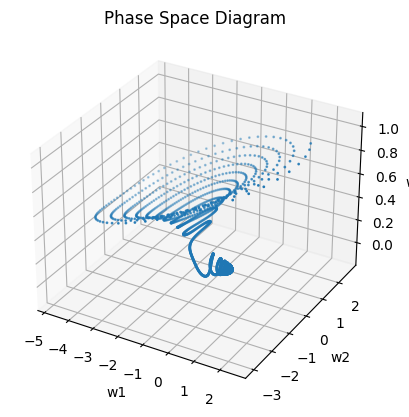

In [662]:
def main():
    inertia = np.array([0.2, 0.3, 4])  # Inertia tensor components (I1, I2, I3)
    initial_state = np.array([1, 1, 1])  # Initial angular velocities (w1, w2, w3)
    r_cm = np.array([0.1, 0, 0])  # Position vector of the center of mass (x_cm, y_cm, z_cm)
    m = 5  # Mass of the rigid body
    g = 9.81  # Gravitational acceleration
    damping = np.array([0.05, 0.05, 0.05])  # Damping coefficients (b1, b2, b3)
    t_total = 60  # Total simulation time
    dt = 0.01  # Time step

    t, states = simulate(inertia, initial_state, r_cm, m, g, damping, t_total, dt)
    transition_time = find_sleeping_period_end_time(states, t, dt)

    plt.figure()
    plt.plot(t, states[:, 0], label="w1")
    plt.plot(t, states[:, 1], label="w2")
    plt.plot(t, states[:, 2], label="w3")
    plt.axvline(x=transition_time, color='r', linestyle='--', label="End of Sleeping Period")
    plt.xlabel("Time")
    plt.ylabel("Angular Velocity")
    plt.title("Rotation of a Rigid Body with Gravitational Torque and Damping")
    plt.legend()
    plt.show()

    plot_phase_space(states)

if __name__ == "__main__":
    main()